<a href="https://colab.research.google.com/github/ramaastra/sekarya-machine-learning/blob/main/sekarya_model_with_kfold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sekarya Machine Learning Model (Development)

This notebook containing some experiments of machine learning model development for Sekarya's main feature, to classify wheter an artwork is generated by AI or not.

For the model itself, the training will be done with a custom dataset we've collected below. For addition to the imbalanced ai_generated class in the dataset, we also add more data from Kaggle. And for testing purpose, the dataset will be used from Kaggle to represent independent data.

- [Sekarya Dataset](https://drive.google.com/drive/folders/1W_DN02xlxOB9M_P27_TJJNuhdxEQY9Kf?usp=drive_link)
- [Addition AI-generated Dataset](https://www.kaggle.com/datasets/gauravduttakiit/dalle-recognition-dataset)
- [Test Dataset](https://www.kaggle.com/datasets/macayanpioloc/ai-generated-and-human-made-painting)

## Preparing the Dataset

### Getting the Sekarya Dataset from Google Drive

In [18]:
from google.colab import drive
import os

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls drive/MyDrive/New-Sekarya-Dataset/

test  train


In [ ]:
drive_dataset_dir = '/content/drive/MyDrive/New-Sekarya-Dataset/'
os.listdir(drive_dataset_dir)

['train', 'test']

In [ ]:
drive_train_dir = os.path.join(drive_dataset_dir, 'train')
os.listdir(drive_train_dir)

['ai_generated', 'non_ai_generated']

In [ ]:
drive_train_fake_dir = os.path.join(drive_train_dir, 'ai_generated')
drive_train_real_dir = os.path.join(drive_train_dir, 'non_ai_generated')

print(f'There are {len(os.listdir(drive_train_fake_dir))} images of fake (AI-generated) artworks for training.\n')
print(f'There are {len(os.listdir(drive_train_real_dir))} images of real (human-made artworks) images for training.\n')

There are 331 images of fake (AI-generated) artworks for training.

There are 2501 images of real (human-made artworks) images for training.



### Getting Additional Dataset from Kaggle

In [ ]:
from google.colab import files
import os

if not(os.path.exists("kaggle.json")):
  files.upload()
!pip install --upgrade --force-reinstall --no-deps kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.16-py3-none-any.whl size=110683 sha256=2a8f6396cd7d6847ed8485f9ced4e6dfcc911073b4c4c775c00916a377bd2464
  Stored in directory: /root/.cache/pip/wheels/43/4b/fb/736478af5e8004810081a06259f9aa2f7c3329fc5d03c2c412
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.16
    Uninstalling kaggle-1.5.16:
      Successfully uninstalled kaggle-1.5.16
kaggle.json


In [ ]:
dataset_url = 'gauravduttakiit/dalle-recognition-dataset'
dataset_name = dataset_url.split('/')[1]
!kaggle datasets download -d  {dataset_url}
!mkdir {dataset_name}
!unzip -q {dataset_name}.zip -d {dataset_name}
!rm -f {dataset_name}.zip

 98% 1.33G/1.35G [00:18<00:00, 99.7MB/s]
100% 1.35G/1.35G [00:18<00:00, 79.0MB/s]


In [ ]:
kaggle_train_fake_dir = f'/content/{dataset_name}/train/fake'
print(f'There are {len(os.listdir(kaggle_train_fake_dir))} additional images of fake (AI-generated) artworks for training.\n')

There are 2057 additional images of fake (AI-generated) artworks for training.



### Storing Data File Paths and Labels to a List

In [ ]:
images = []
labels = []

# Dataset from Google Drive
class_labels = os.listdir(drive_train_dir)
for class_label in class_labels:
  class_data_path = os.path.join(drive_train_dir, class_label)
  for filename in os.listdir(class_data_path):
    file_path = os.path.join(class_data_path, filename)
    images.append(file_path)
    labels.append(class_label)

# Additional AI-generated class data from Kaggle
for filename in os.listdir(kaggle_train_fake_dir):
  file_path = os.path.join(kaggle_train_fake_dir, filename)
  images.append(file_path)
  labels.append('ai_generated')

print(f'There are {len(images)} images will be splitted with K-fold cross-validation technique.\n')

There are 4889 images will be splitted with K-fold cross-validation technique.



## Preparing the Model Architecture

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import numpy as np

### Defining a Function to Handle Model Creation

In [ ]:
def create_model(pretrained=False):
  model = tf.keras.Sequential()

  if pretrained:
    vgg19 = VGG19(input_shape=(224, 224, 3),
                            include_top=False,
                            weights='imagenet')

    for layer in vgg19.layers:
      layer.trainable = False

    model.add(vgg19)
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(64, activation='relu'))

  else:
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(tf.keras.layers.MaxPooling2D(2, 2))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(2, 2))
    model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(2, 2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(0.1))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(32, activation='relu'))

  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

  model.compile(optimizer=Adam(learning_rate=1e-4),
                loss=BinaryCrossentropy(),
                metrics=['accuracy'])

  return model

### Defining EarlyStopping Callback

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               mode='min',
                               restore_best_weights=True)

## Creating Models

In [21]:
cnn_model = create_model()
cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 26, 26, 128)      

In [22]:
vgg19_model = create_model(pretrained=True)
vgg19_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_3 (Dropout)         (None, 25088)             0         
                                                                 
 dense_9 (Dense)             (None, 128)               3211392   
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 23244097 (88.67 MB)
Trainable params: 32

## Training the Model with K-fold Cross-validation

In [ ]:
num_folds = 5
kfold = StratifiedKFold(n_splits=num_folds)

In [23]:
def train_kfold(model, model_name):
  model_histories = []

  for k, (train_indices, val_indices) in enumerate(kfold.split(images, labels)):
    print(f'[Processing Fold-{k}...]\n')

    # Creating lists for images and labels based on the train and val indices
    x_train = [images[i] for i in train_indices]
    y_train = [labels[i] for i in train_indices]
    x_val = [images[i] for i in val_indices]
    y_val = [labels[i] for i in val_indices]

    # Creating dataframe for each train and val list
    train_df = pd.DataFrame({
      'image': x_train,
      'label': y_train
    })
    val_df = pd.DataFrame({
      'image': x_val,
      'label': y_val
    })

    # Creating the image generator to process the images
    train_datagen = ImageDataGenerator(rescale=1./255.0)
    val_datagen = ImageDataGenerator(rescale=1./255.0)

    train_generator = train_datagen.flow_from_dataframe(train_df,
                                                        x_col='image',
                                                        y_col='label',
                                                        target_size=(224, 224),
                                                        batch_size=32,
                                                        color_mode='rgb',
                                                        class_mode='binary')

    val_generator = val_datagen.flow_from_dataframe(val_df,
                                                    x_col='image',
                                                    y_col='label',
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    color_mode='rgb',
                                                    class_mode='binary')

    print()

    # Train the model for this fold
    history = model.fit(train_generator,
                        epochs=20,
                        validation_data=val_generator,
                        verbose=1,
                        callbacks=[early_stopping])

    # Storing the model history into the list
    model_histories.append(history)

    # Evaluate the model on the validation set
    _, accuracy = model.evaluate(val_generator, verbose=0)
    print(f'\nValidation accuracy for fold-{k}: {accuracy:.4f}')

    print('\n==============================================================\n')

  # Save the model into models directory
  model.save(f'/content/models/{model_name}.h5')

  return model_histories

In [25]:
cnn_histories = train_kfold(cnn_model, 'cnn_model')

[Processing Fold-0...]

Found 3911 validated image filenames belonging to 2 classes.
Found 978 validated image filenames belonging to 2 classes.

Epoch 1/20
123/123 [==============================] - 92s 736ms/step - loss: 0.6523 - accuracy: 0.6060 - val_loss: 0.4794 - val_accuracy: 0.8303
Epoch 2/20
123/123 [==============================] - 74s 601ms/step - loss: 0.5340 - accuracy: 0.7228 - val_loss: 0.3962 - val_accuracy: 0.8364
Epoch 3/20
123/123 [==============================] - 74s 608ms/step - loss: 0.4842 - accuracy: 0.7627 - val_loss: 0.3724 - val_accuracy: 0.8548
Epoch 4/20
123/123 [==============================] - 77s 622ms/step - loss: 0.4491 - accuracy: 0.7975 - val_loss: 0.2991 - val_accuracy: 0.8834
Epoch 5/20
123/123 [==============================] - 90s 738ms/step - loss: 0.4134 - accuracy: 0.8174 - val_loss: 0.2681 - val_accuracy: 0.9131
Epoch 6/20
123/123 [==============================] - 89s 731ms/step - loss: 0.3756 - accuracy: 0.8394 - val_loss: 0.2738 - val_a

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
vgg19_histories = train_kfold(vgg19_model, 'vgg19_model')

[Processing Fold-0...]

Found 3911 validated image filenames belonging to 2 classes.
Found 978 validated image filenames belonging to 2 classes.

Epoch 1/20
123/123 [==============================] - 100s 754ms/step - loss: 0.5580 - accuracy: 0.7088 - val_loss: 0.4083 - val_accuracy: 0.7965
Epoch 2/20
123/123 [==============================] - 79s 645ms/step - loss: 0.4070 - accuracy: 0.8133 - val_loss: 0.3248 - val_accuracy: 0.8569
Epoch 3/20
123/123 [==============================] - 79s 640ms/step - loss: 0.3150 - accuracy: 0.8706 - val_loss: 0.4070 - val_accuracy: 0.8149
Epoch 4/20
123/123 [==============================] - 83s 669ms/step - loss: 0.2664 - accuracy: 0.8916 - val_loss: 0.2978 - val_accuracy: 0.8609
Epoch 5/20
123/123 [==============================] - 78s 637ms/step - loss: 0.2075 - accuracy: 0.9192 - val_loss: 0.2792 - val_accuracy: 0.8824
Epoch 6/20
123/123 [==============================] - 78s 630ms/step - loss: 0.1688 - accuracy: 0.9389 - val_loss: 0.2754 - val_

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Getting the Training Result

### Overall Accuracy and Loss

In [231]:
def get_result(histories, model_name):
  print(f'{model_name} Model Result:')
  print(f"- {histories[-1].history['accuracy'][-1]:.4f} accuracy")
  print(f"- {histories[-1].history['val_accuracy'][-1]:.4f} validation accuracy")
  print(f"- {histories[-1].history['loss'][-1]:.4f} loss")
  print(f"- {histories[-1].history['val_loss'][-1]:.4f} validation loss")

In [232]:
get_result(cnn_histories, model_name='CNN')

CNN Model Result:
- 0.9997 accuracy
- 0.9928 validation accuracy
- 0.0077 loss
- 0.0218 validation loss


In [233]:
get_result(vgg19_histories, model_name='VGG19')

VGG19 Model Result:
- 0.9957 accuracy
- 0.9918 validation accuracy
- 0.0173 loss
- 0.0303 validation loss


### Plotting the Training Result

In [26]:
import matplotlib.pyplot as plt

In [116]:
def plot_train_result(histories, model_name):
  combined_history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

  # Merge all metrics of all folds
  for history in histories:
    combined_history['loss'] += history.history['loss']
    combined_history['val_loss'] += history.history['val_loss']
    combined_history['accuracy'] += history.history['accuracy']
    combined_history['val_accuracy'] += history.history['val_accuracy']

  plt.figure(figsize=(12, 4))
  plt.subplots_adjust(top=0.8)
  plt.suptitle(f'Training Result of {model_name} Model', fontsize=16)

  # Plot combined training and validation accuracy
  plt.subplot(1, 2, 1)
  plt.plot(combined_history['accuracy'], label='Train')
  plt.plot(combined_history['val_accuracy'], label='Val')
  plt.title('Training and Validation Accuracy (All Folds Combined)')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  # Plot combined training and validation loss
  plt.subplot(1, 2, 2)
  plt.plot(combined_history['loss'], label='Train')
  plt.plot(combined_history['val_loss'], label='Val')
  plt.title('Training and Validation Loss (All Folds Combined)')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.show()

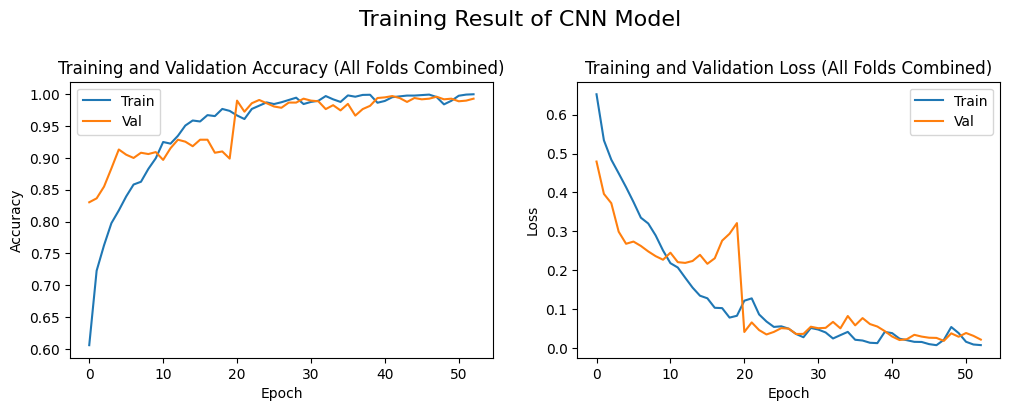

In [117]:
plot_train_result(cnn_histories, model_name='CNN')

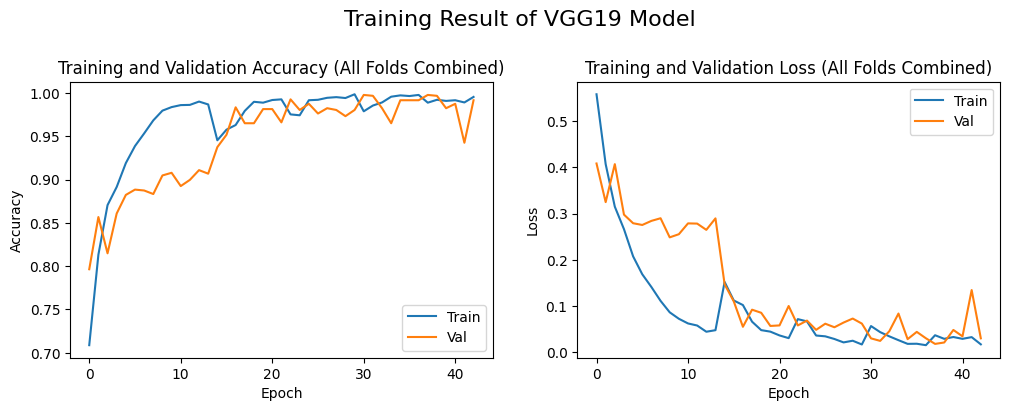

In [118]:
plot_train_result(vgg19_histories, model_name='VGG19')

## Evaluating the Model with Confusion Matrix

In [199]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### Getting the Test Set from Kaggle

In [30]:
from google.colab import files
import os

if not(os.path.exists("kaggle.json")):
  files.upload()
!pip install --upgrade --force-reinstall --no-deps kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

  Using cached kaggle-1.5.16-py3-none-any.whl
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.16
    Uninstalling kaggle-1.5.16:
      Successfully uninstalled kaggle-1.5.16
kaggle.json


In [31]:
dataset_url = 'macayanpioloc/ai-generated-and-human-made-painting'
dataset_name = dataset_url.split('/')[1]
!kaggle datasets download -d  {dataset_url}
!mkdir {dataset_name}
!unzip -q {dataset_name}.zip -d {dataset_name}
!rm -f {dataset_name}.zip

 99% 403M/407M [00:07<00:00, 74.9MB/s]
100% 407M/407M [00:07<00:00, 58.6MB/s]


In [32]:
test_dir = f'/content/{dataset_name}/224/val'
os.listdir(test_dir)

['AI_GENERATED', 'NON_AI_GENERATED']

### Evaluating Model Predictions on the Test Set

In [33]:
test_datagen = ImageDataGenerator(rescale=1./255.0)
test_generator = test_datagen.flow_from_directory(directory=test_dir,
                                                  batch_size=32,
                                                  class_mode='binary',
                                                  target_size=(224, 224))

Found 5884 images belonging to 2 classes.


In [34]:
# True label for the test set
y_true = test_generator.classes

In [35]:
# Loading the model
vgg19_model = tf.keras.models.load_model('/content/models/vgg19_model.h5')
cnn_model = tf.keras.models.load_model('/content/models/cnn_model.h5')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_3 (Dropout)         (None, 25088)             0         
                                                                 
 dense_9 (Dense)             (None, 128)               3211392   
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 23244097 (88.67 MB)
Trainable params: 32

In [129]:
def create_cm(model, model_name, threshold=0.5):
  # Generating predictions with the model to the test set
  predictions = model.predict(test_generator)

  # Converting the probabilites into binary class
  y_pred = (predictions > threshold).astype(int)

  # Creating confusion matrix
  cm = confusion_matrix(y_true, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=['ai_generated', 'non_ai_generated'])

  _, ax = plt.subplots()
  ax.set_title(f'Confusion Matrix of {model_name} Model')

  disp.plot(ax=ax)

184/184 [==============================] - 9s 51ms/step


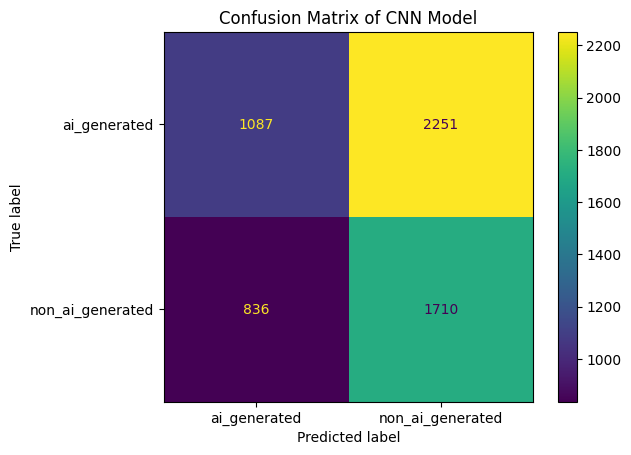

In [134]:
create_cm(cnn_model, model_name='CNN')

184/184 [==============================] - 27s 148ms/step


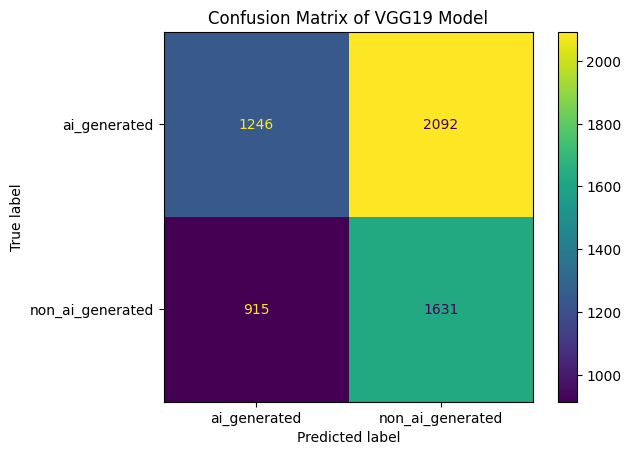

In [135]:
create_cm(vgg19_model, model_name='VGG19')

### Testing the Model with Some Images

In [136]:
import random
import matplotlib.image as mpimg

In [137]:
test_fake_dir = os.path.join(test_dir, 'AI_GENERATED')
test_real_dir = os.path.join(test_dir, 'NON_AI_GENERATED')

In [187]:
def test_sample_images(model, model_name, test_dir, threshold=0.5):
  fig = plt.figure(figsize=(10, 3))
  row = 1
  sample_size = 5

  random_images = random.sample(os.listdir(test_dir), sample_size)

  for i, image in enumerate(random_images):
    fig.add_subplot(row, sample_size, i+1)

    image_path = f'{test_dir}/{image}'
    img = mpimg.imread(image_path)

    x = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
    y_pred = model.predict(x, verbose=0)
    y_pred = (y_pred > threshold).astype(int)
    y_true = 0 if test_dir.split('/')[-1] == 'AI_GENERATED' else 1

    pred_label = 'Fake' if y_pred == 0 else 'Real'
    title = plt.title(f'Prediction: {pred_label}')
    plt.setp(title, color=('g' if y_pred == y_true else 'r'))
    plt.imshow(img)
    plt.axis('off')

  fig.suptitle(f"{model_name} Model Prediction on {test_dir.split('/')[-1]} Images", fontsize=16)

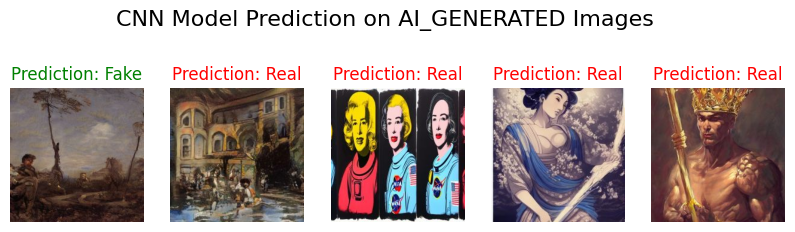

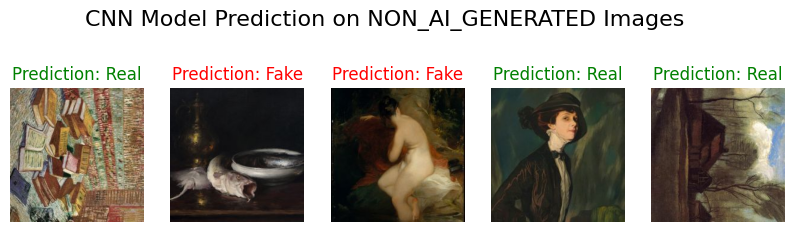

In [198]:
test_sample_images(cnn_model, 'CNN', test_fake_dir)
test_sample_images(cnn_model, 'CNN', test_real_dir)

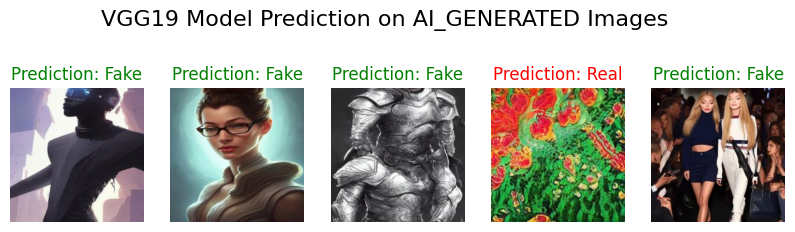

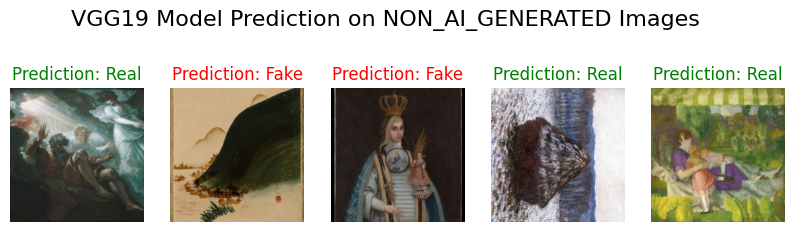

In [195]:
test_sample_images(vgg19_model, 'VGG19', test_fake_dir)
test_sample_images(vgg19_model, 'VGG19', test_real_dir)